In [1]:
#!pip install -r ../requirements.txt

In [36]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import spacy
import nltk
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [37]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/axs0112a/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
data_dir = '/Users/axs0112a/Desktop/kaggle-competitions/feedback-prize/'

In [5]:
train_annotated = pd.read_csv(data_dir + 'data/train.csv')

train_annotated[['discourse_id', 'discourse_start', 'discourse_end']] = train_annotated[['discourse_id', 'discourse_start', 'discourse_end']].astype(int)

sample_submission = pd.read_csv(data_dir + 'data/sample_submission.csv')

In [6]:
#The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell

train_txt_filenames = glob(data_dir + 'data/train/*.txt') ## Returns a list of filenames matching the pattern
test_txt_filenames = glob(data_dir + 'data/test/*.txt')

In [7]:
len(train_txt_filenames), train_annotated['id'].nunique()

(15594, 15594)

In [8]:
!cat ../data/train/423A1CA112E2.txt

Phones

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.

When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.

Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. S

In [9]:
train_annotated.query('id == "423A1CA112E2"')

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622630000000,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622630000000,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622630000000,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622630000000,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622630000000,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...
5,423A1CA112E2,1622630000000,887,1150,That's why there's a thing that's called no te...,Evidence,Evidence 3,163 164 165 166 167 168 169 170 171 172 173 17...
6,423A1CA112E2,1622630000000,1151,1533,Sometimes on the news there is either an accid...,Evidence,Evidence 4,211 212 213 214 215 216 217 218 219 220 221 22...
7,423A1CA112E2,1622630000000,1534,1602,Phones are fine to use and it's also the best ...,Claim,Claim 2,282 283 284 285 286 287 288 289 290 291 292 29...
8,423A1CA112E2,1622630000000,1603,1890,If you go through a problem and you can't find...,Evidence,Evidence 5,297 298 299 300 301 302 303 304 305 306 307 30...
9,423A1CA112E2,1622630000000,1891,2027,The news always updated when people do somethi...,Concluding Statement,Concluding Statement 1,355 356 357 358 359 360 361 362 363 364 365 36...


## Check 1 : discourse_text vs prediction string

In [10]:
#add columns
train_annotated["discourse_len"] = train_annotated["discourse_text"].apply(lambda x: len(x.split()))
train_annotated["pred_len"] = train_annotated["predictionstring"].apply(lambda x: len(x.split()))


cols_to_display = ['discourse_id', 'discourse_text', 'discourse_type','predictionstring', 'discourse_len', 'pred_len','id']
train_annotated[cols_to_display].head()

,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len,id
0,1622630000000,Modern humans today are always on their phone....,Lead,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,44,44,423A1CA112E2
1,1622630000000,They are some really bad consequences when stu...,Position,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,15,15,423A1CA112E2
2,1622630000000,Some certain areas in the United States ban ph...,Evidence,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,16,16,423A1CA112E2
3,1622630000000,"When people have phones, they know about certa...",Evidence,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,63,63,423A1CA112E2
4,1622630000000,Driving is one of the way how to get around. P...,Claim,139 140 141 142 143 144 145 146 147 148 149 15...,24,24,423A1CA112E2


In [11]:
print(f"The total number of discourses is {len(train_annotated)}")
train_annotated.query('discourse_len != pred_len')[cols_to_display]

The total number of discourses is 144293


,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len,id
107,1622470000000,if we would just make stricker laws for phone ...,Concluding Statement,303 304 305 306 307 308 309 310 311 312 313 31...,19,18,C3811E7F1750
1025,1622560000000,for navigation to wherever they are going,Claim,105 106 107 108 109 110 111 112,7,8,372F4B66B279
1525,1622990000000,People should not be able to use cell phones w...,Position,22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 3...,47,48,4E1C636ABEAD
1526,1622990000000,"First, cell phones are a benefit and allows ev...",Claim,69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 8...,21,22,4E1C636ABEAD
1527,1622990000000,"Kids, teenagers, adults, even grandparents hav...",Evidence,90 91 92 93 94 95 96 97 98 99 100 101 102 103 ...,78,79,4E1C636ABEAD
...,...,...,...,...,...,...,...
142607,1617830000000,seeking people's opinions on making a choice i...,Concluding Statement,563 564 565 566 567 568 569 570 571 572 573 57...,51,50,5EF21F142C51
143191,1617890000000,i feel like for the bst advice ask more then o...,Evidence,185 186 187 188 189 190 191 192 193 194 195 19...,83,82,C0643251A96A
143227,1617650000000,", asking for advice from multiple people will ...",Concluding Statement,467 468 469 470 471 472 473 474 475 476 477 47...,84,83,871287046F85
143311,1618290000000,Seeking multiple opinions can help make a bett...,Claim,159 160 161 162 163 164 165 166 167 168 169 17...,15,16,B7BD520BE938


In [12]:
print(train_annotated.query('discourse_id == 1622470000000')['discourse_text'].values[0])
print(train_annotated.query('discourse_id == 1622470000000')['discourse_text'].values[0].split())
print(len(train_annotated.query('discourse_id == 1622470000000')['discourse_text'].values[0].split()))

BOOM!! You're on I-75 on the ground bleeding out watching everyone surrounding you, calling 911.

At this point you're thinking to yourself, "why the freak did this happen?" A couple hours later you found out an adult was on his phone texting and driving before the wreck happened, which is the most selfish thing to do while driving. Putting your life and other's lives in danger just so you can send a stupid text to your girl/boyfriend is completely selfish 
['BOOM!!', "You're", 'on', 'I-75', 'on', 'the', 'ground', 'bleeding', 'out', 'watching', 'everyone', 'surrounding', 'you,', 'calling', '911.', 'At', 'this', 'point', "you're", 'thinking', 'to', 'yourself,', '"why', 'the', 'freak', 'did', 'this', 'happen?"', 'A', 'couple', 'hours', 'later', 'you', 'found', 'out', 'an', 'adult', 'was', 'on', 'his', 'phone', 'texting', 'and', 'driving', 'before', 'the', 'wreck', 'happened,', 'which', 'is', 'the', 'most', 'selfish', 'thing', 'to', 'do', 'while', 'driving.', 'Putting', 'your', 'life', 'a

## correlation between the length of a discourse and the class (discourse_type)

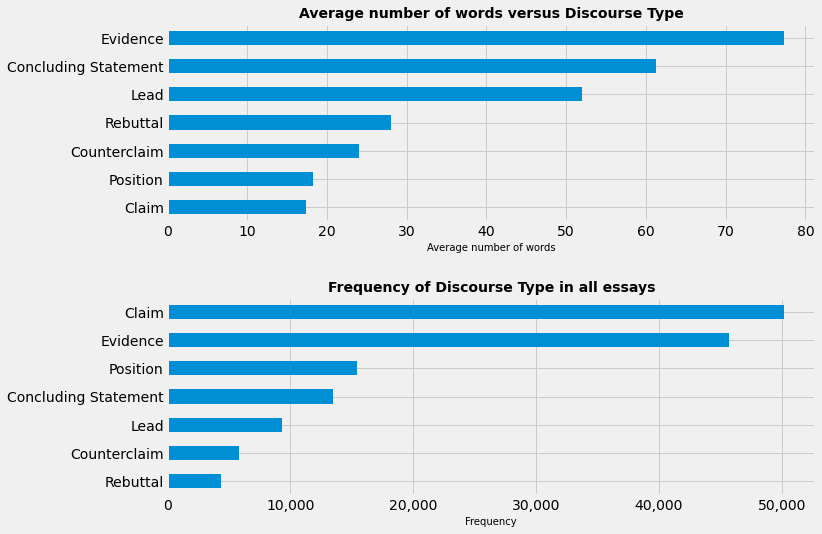

In [13]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
ax1 = train_annotated.groupby('discourse_type')['discourse_len'].mean().sort_values().plot(kind="barh")
ax1.set_title("Average number of words versus Discourse Type", fontsize=14, fontweight = 'bold')
ax1.set_xlabel("Average number of words", fontsize = 10)
ax1.set_ylabel("")

ax2 = fig.add_subplot(212)
ax2 = train_annotated.groupby('discourse_type')['discourse_type'].count().sort_values().plot(kind="barh")
ax2.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
ax2.set_title("Frequency of Discourse Type in all essays", fontsize=14, fontweight = 'bold')
ax2.set_xlabel("Frequency", fontsize = 10)
ax2.set_ylabel("")

plt.tight_layout(pad=2)
plt.show()

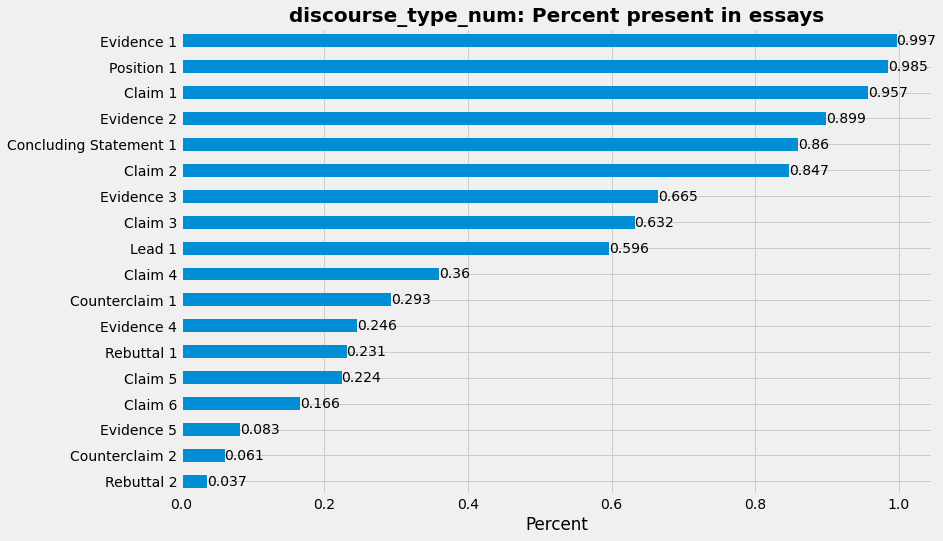

In [14]:
fig = plt.figure(figsize=(12,8))
av_per_essay = train_annotated['discourse_type_num'].value_counts(ascending = True).rename_axis('discourse_type_num').reset_index(name='count')
av_per_essay['perc'] = round((av_per_essay['count'] / train_annotated.id.nunique()),3)
av_per_essay = av_per_essay.set_index('discourse_type_num')
ax = av_per_essay.query('perc > 0.03')['perc'].plot(kind="barh")
ax.set_title("discourse_type_num: Percent present in essays", fontsize=20, fontweight = 'bold')
ax.bar_label(ax.containers[0], label_type="edge")
ax.set_xlabel("Percent")
ax.set_ylabel("")
plt.show()

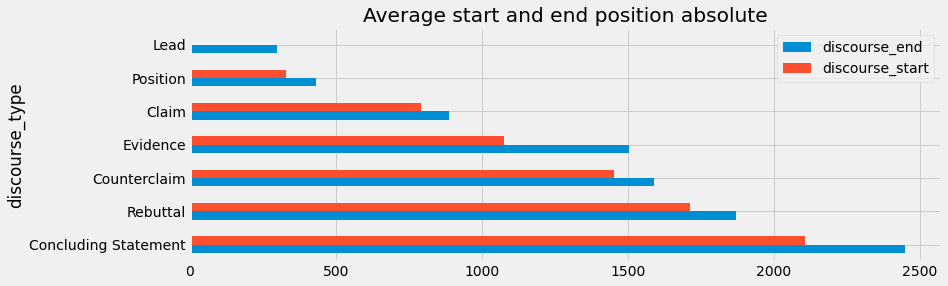

In [15]:
data = train_annotated.groupby("discourse_type")[['discourse_end', 'discourse_start']].mean().reset_index().sort_values(by = 'discourse_start', ascending = False)
data.plot(x='discourse_type',
        kind='barh',
        stacked=False,
        title='Average start and end position absolute',
        figsize=(12,4))
plt.show()

In [16]:
train_first = train_annotated.drop_duplicates(subset = "id", keep = "first").discourse_type.value_counts().rename_axis('discourse_type').reset_index(name='counts_first')
train_first['percent_first'] = round((train_first['counts_first']/train_annotated.id.nunique()),2)
train_last = train_annotated.drop_duplicates(subset = "id", keep = "last").discourse_type.value_counts().rename_axis('discourse_type').reset_index(name='counts_last')
train_last['percent_last'] = round((train_last['counts_last']/train_annotated.id.nunique()),2)
train_first_last = train_first.merge(train_last, on = "discourse_type", how = "left")
train_first_last

,discourse_type,counts_first,percent_first,counts_last,percent_last
0,Lead,9298,0.60,3,0.00
1,Position,5760,0.37,521,0.03
2,Evidence,261,0.02,1609,0.10
3,Claim,255,0.02,285,0.02
4,Counterclaim,19,0.00,30,0.00
5,Concluding Statement,1,0.00,12993,0.83


In [17]:
train_annotated['discourse_nr'] = 1
counter = 1

for i in tqdm(range(1, len(train_annotated))):
    if train_annotated.loc[i, 'id'] == train_annotated.loc[i-1, 'id']:
        counter += 1
        train_annotated.loc[i, 'discourse_nr'] = counter
    else:
        counter = 1
        train_annotated.loc[i, 'discourse_nr'] = counter

#if you are interested in other discourse_types you can add them to the list in df.query
train_annotated.query('discourse_type in ["Lead"]').groupby('discourse_type_num')['discourse_nr'].value_counts().to_frame('occurences')

  0%|          | 0/144292 [00:00<?, ?it/s]

occurences
discourse_type_num discourse_nr            
Lead 1             1                   9298
                   2                      3
Lead 2             2                      1
                   10                     1
                   15                     1
                   16                     1

In [19]:
# this code chunk is copied from Rob Mulla
len_dict = {}
word_dict = {}
for t in tqdm(train_txt_filenames):
    with open(t, "r") as txt_file:
        myid = t.split("/")[-1].replace(".txt", "")
        data = txt_file.read()
        mylen = len(data.strip())
        myword = len(data.split())
        len_dict[myid] = mylen
        word_dict[myid] = myword
train_annotated["essay_len"] = train_annotated["id"].map(len_dict)
train_annotated["essay_words"] = train_annotated["id"].map(word_dict)

  0%|          | 0/15594 [00:00<?, ?it/s]

In [20]:
#initialize column
train_annotated['gap_length'] = np.nan

#set the first one
train_annotated.loc[0, 'gap_length'] = 7 #discourse start - 1 (previous end is always -1)

#loop over rest
for i in tqdm(range(1, len(train_annotated))):
    #gap if difference is not 1 within an essay
    if ((train_annotated.loc[i, "id"] == train_annotated.loc[i-1, "id"])\
        and (train_annotated.loc[i, "discourse_start"] - train_annotated.loc[i-1, "discourse_end"] > 1)):
        train_annotated.loc[i, 'gap_length'] = train_annotated.loc[i, "discourse_start"] - train_annotated.loc[i-1, "discourse_end"] - 2
        #minus 2 as the previous end is always -1 and the previous start always +1
    #gap if the first discourse of an new essay does not start at 0
    elif ((train_annotated.loc[i, "id"] != train_annotated.loc[i-1, "id"])\
        and (train_annotated.loc[i, "discourse_start"] != 0)):
        train_annotated.loc[i, 'gap_length'] = train_annotated.loc[i, "discourse_start"] -1


 #is there any text after the last discourse of an essay?
last_ones = train_annotated.drop_duplicates(subset="id", keep='last')
last_ones['gap_end_length'] = np.where((last_ones.discourse_end < last_ones.essay_len),\
                                       (last_ones.essay_len - last_ones.discourse_end),\
                                       np.nan)

cols_to_merge = ['id', 'discourse_id', 'gap_end_length']
train_annotated = train_annotated.merge(last_ones[cols_to_merge], on = ["id", "discourse_id"], how = "left")

  0%|          | 0/144292 [00:00<?, ?it/s]

In [21]:
#display an example
cols_to_display = ['id', 'discourse_start', 'discourse_end', 'discourse_type', 'essay_len', 'gap_length', 'gap_end_length']
train_annotated[cols_to_display].query('id == "AFEC37C2D43F"')

,id,discourse_start,discourse_end,discourse_type,essay_len,gap_length,gap_end_length
144270,AFEC37C2D43F,0,317,Lead,3140.0,NaN,NaN
144271,AFEC37C2D43F,318,515,Position,3140.0,NaN,NaN
144272,AFEC37C2D43F,684,692,Claim,3140.0,167.0,NaN
144273,AFEC37C2D43F,693,710,Claim,3140.0,NaN,NaN
144274,AFEC37C2D43F,714,724,Claim,3140.0,2.0,NaN
144275,AFEC37C2D43F,725,1360,Evidence,3140.0,NaN,NaN
144276,AFEC37C2D43F,1361,1471,Claim,3140.0,NaN,NaN
144277,AFEC37C2D43F,1472,1881,Evidence,3140.0,NaN,NaN
144278,AFEC37C2D43F,1882,2019,Claim,3140.0,NaN,NaN
144279,AFEC37C2D43F,2029,2123,Claim,3140.0,8.0,NaN


In [22]:
#how many pieces of tekst are not used as discourses?

print(f"Besides the {len(train_annotated)} discourse texts, there are {len(train_annotated.query('gap_length.notna()', engine='python'))+ len(train_annotated.query('gap_end_length.notna()', engine='python'))} pieces of text not classified.")

Besides the 144293 discourse texts, there are 53515 pieces of text not classified.


In [23]:
train_annotated.sort_values(by = "gap_length", ascending = False)[cols_to_display].head()

,id,discourse_start,discourse_end,discourse_type,essay_len,gap_length,gap_end_length
12921,7330313ED3F0,3377,3846,Concluding Statement,3829.0,2245.0,NaN
20537,7DF12B42AB72,3596,4231,Rebuttal,6012.0,2232.0,45.0
11685,4DF55925F544,2845,3013,Evidence,3846.0,2137.0,NaN
88336,43CBE96B374E,3115,3371,Concluding Statement,3689.0,1726.0,318.0
103994,134A4DA02013,2049,2176,Claim,3301.0,1680.0,NaN


In [24]:
train_annotated.sort_values(by = "gap_end_length", ascending = False)[cols_to_display].head()

,id,discourse_start,discourse_end,discourse_type,essay_len,gap_length,gap_end_length
28131,C278EDC82048,226,243,Claim,8015.0,NaN,7348.0
28127,C278EDC82048,0,107,Lead,8015.0,NaN,7348.0
28132,C278EDC82048,249,277,Claim,8015.0,4.0,7348.0
28133,C278EDC82048,278,524,Evidence,8015.0,NaN,7348.0
28134,C278EDC82048,524,667,Evidence,8015.0,NaN,7348.0


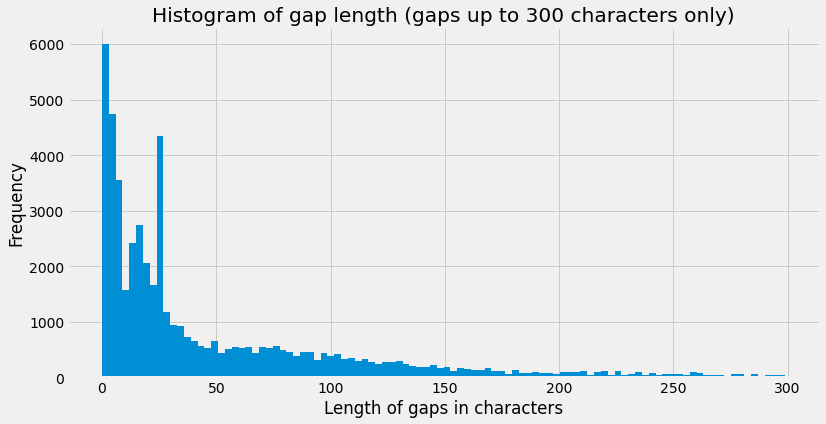

In [25]:
all_gaps = (train_annotated.gap_length[~train_annotated.gap_length.isna()]).append((train_annotated.gap_end_length[~train_annotated.gap_end_length.isna()]), ignore_index= True)
#filter outliers
all_gaps = all_gaps[all_gaps<300]
fig = plt.figure(figsize=(12,6))
all_gaps.plot.hist(bins=100)
plt.title("Histogram of gap length (gaps up to 300 characters only)")
plt.xticks(rotation=0)
plt.xlabel("Length of gaps in characters")
plt.show()

In [26]:
total_gaps = train_annotated.groupby('id').agg({'essay_len': 'first',\
                                               'gap_length': 'sum',\
                                               'gap_end_length': 'sum'})
total_gaps['perc_not_classified'] = round(((total_gaps.gap_length + total_gaps.gap_end_length)/total_gaps.essay_len),2)

total_gaps.sort_values(by = 'perc_not_classified', ascending = False).head()

,essay_len,gap_length,gap_end_length,perc_not_classified
id,,,,
C278EDC82048,8015.0,13.0,58784.0,7.34
B39F2225875C,6852.0,17.0,31739.0,4.63
F6CA5589DCDA,3741.0,0.0,16920.0,4.52
129497C3E0FC,3616.0,130.0,15865.0,4.42
62C6123BCB19,2293.0,8.0,9512.0,4.15


In [27]:
def add_gap_rows(essay):
    cols_to_keep = ['discourse_start', 'discourse_end', 'discourse_type', 'gap_length', 'gap_end_length']
    df_essay = train_annotated.query('id == @essay')[cols_to_keep].reset_index(drop = True)

    #index new row
    insert_row = len(df_essay)
   
    for i in range(1, len(df_essay)):          
        if df_essay.loc[i,"gap_length"] >0:
            if i == 0:
                start = 0 #as there is no i-1 for first row
                end = df_essay.loc[0, 'discourse_start'] -1
                disc_type = "Nothing"
                gap_end = np.nan
                gap = np.nan
                df_essay.loc[insert_row] = [start, end, disc_type, gap, gap_end]
                insert_row += 1
            else:
                start = df_essay.loc[i-1, "discourse_end"] + 1
                end = df_essay.loc[i, 'discourse_start'] -1
                disc_type = "Nothing"
                gap_end = np.nan
                gap = np.nan
                df_essay.loc[insert_row] = [start, end, disc_type, gap, gap_end]
                insert_row += 1

    df_essay = df_essay.sort_values(by = "discourse_start").reset_index(drop=True)

    #add gap at end
    if df_essay.loc[(len(df_essay)-1),'gap_end_length'] > 0:
        start = df_essay.loc[(len(df_essay)-1), "discourse_end"] + 1
        end = start + df_essay.loc[(len(df_essay)-1), 'gap_end_length']
        disc_type = "Nothing"
        gap_end = np.nan
        gap = np.nan
        df_essay.loc[insert_row] = [start, end, disc_type, gap, gap_end]
        
    return(df_essay)

In [28]:
add_gap_rows("129497C3E0FC")

,discourse_start,discourse_end,discourse_type,gap_length,gap_end_length
0,0,57.0,Lead,NaN,3173.0
1,58,111.0,Claim,NaN,3173.0
2,112,120.0,Nothing,NaN,NaN
3,121,137.0,Claim,8.0,3173.0
4,138,157.0,Nothing,NaN,NaN
5,158,281.0,Counterclaim,19.0,3173.0
6,282,385.0,Nothing,NaN,NaN
7,386,443.0,Position,103.0,3173.0
8,444,3617.0,Nothing,NaN,NaN


In [32]:
def print_colored_essay(essay):
    df_essay = add_gap_rows(essay)
    #code from https://www.kaggle.com/odins0n/feedback-prize-eda, but adjusted to df_essay
    essay_file = data_dir + 'data/train/' + essay + ".txt"

    ents = []
    for i, row in df_essay.iterrows():
        ents.append({
                        'start': int(row['discourse_start']), 
                         'end': int(row['discourse_end']), 
                         'label': row['discourse_type']
                    })

    with open(essay_file, 'r') as file: data = file.read()

    doc2 = {
        "text": data,
        "ents": ents,
    }

    colors = {'Lead': '#EE11D0','Position': '#AB4DE1','Claim': '#1EDE71','Evidence': '#33FAFA','Counterclaim': '#4253C1','Concluding Statement': 'yellow','Rebuttal': 'red'}
    options = {"ents": df_essay.discourse_type.unique().tolist(), "colors": colors}
    spacy.displacy.render(doc2, style="ent", options=options, manual=True, jupyter=True);

In [33]:
print_colored_essay("7330313ED3F0")

# Most used words per Discourse Type

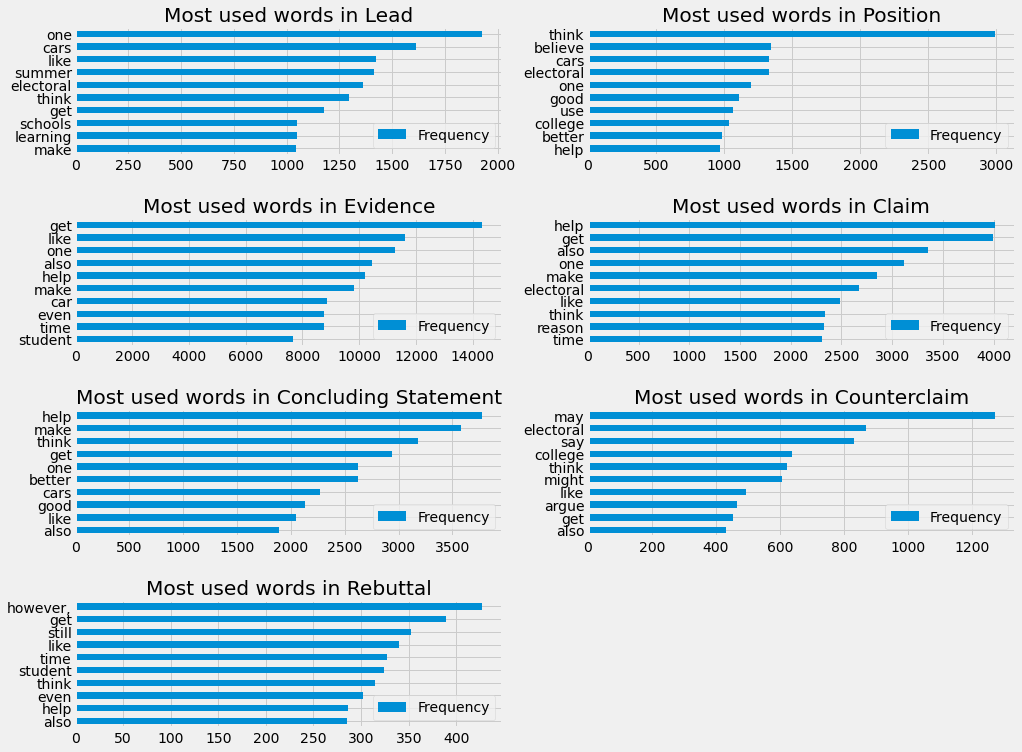

In [38]:
train_annotated['discourse_text'] = train_annotated['discourse_text'].str.lower()

#get stopwords from nltk library
stop_english = stopwords.words("english")
other_words_to_take_out = ['school', 'students', 'people', 'would', 'could', 'many']
stop_english.extend(other_words_to_take_out)

#put dataframe of Top-10 words in dict for all discourse types
counts_dict = {}
for dt in train_annotated['discourse_type'].unique():
    df = train_annotated.query('discourse_type == @dt')
    text = df.discourse_text.apply(lambda x: x.split()).tolist()
    text = [item for elem in text for item in elem]
    df1 = pd.Series(text).value_counts().to_frame().reset_index()
    df1.columns = ['Word', 'Frequency']
    df1 = df1[~df1.Word.isin(stop_english)].head(10)
    df1 = df1.set_index("Word").sort_values(by = "Frequency", ascending = True)
    counts_dict[dt] = df1

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

keys = list(counts_dict.keys())

for n, key in enumerate(keys):
    ax = plt.subplot(4, 2, n + 1)
    ax.set_title(f"Most used words in {key}")
    counts_dict[keys[n]].plot(ax=ax, kind = 'barh')
    plt.ylabel("")

plt.show()

# Making n_grams for each discourse type

In [39]:
def get_n_grams(n_grams, top_n = 10):
    df_words = pd.DataFrame()
    for dt in tqdm(train_annotated['discourse_type'].unique()):
        df = train_annotated.query('discourse_type == @dt')
        texts = df['discourse_text'].tolist()
        vec = CountVectorizer(lowercase = True, stop_words = 'english',\
                              ngram_range=(n_grams, n_grams)).fit(texts)
        bag_of_words = vec.transform(texts)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        cvec_df = pd.DataFrame.from_records(words_freq,\
                                            columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
        cvec_df.insert(0, "Discourse_type", dt)
        cvec_df = cvec_df.iloc[:top_n,:]
        df_words = df_words.append(cvec_df)
    return df_words

In [40]:
bigrams = get_n_grams(n_grams = 2, top_n=10)
bigrams.head()

  0%|          | 0/7 [00:00<?, ?it/s]

,Discourse_type,words,counts
73564,Lead,electoral college,1179
63518,Lead,driverless cars,808
55,Lead,cell phones,592
19359,Lead,summer projects,513
85397,Lead,distance learning,468


# I have also made a function that prints the results in this dataframe as subplots.

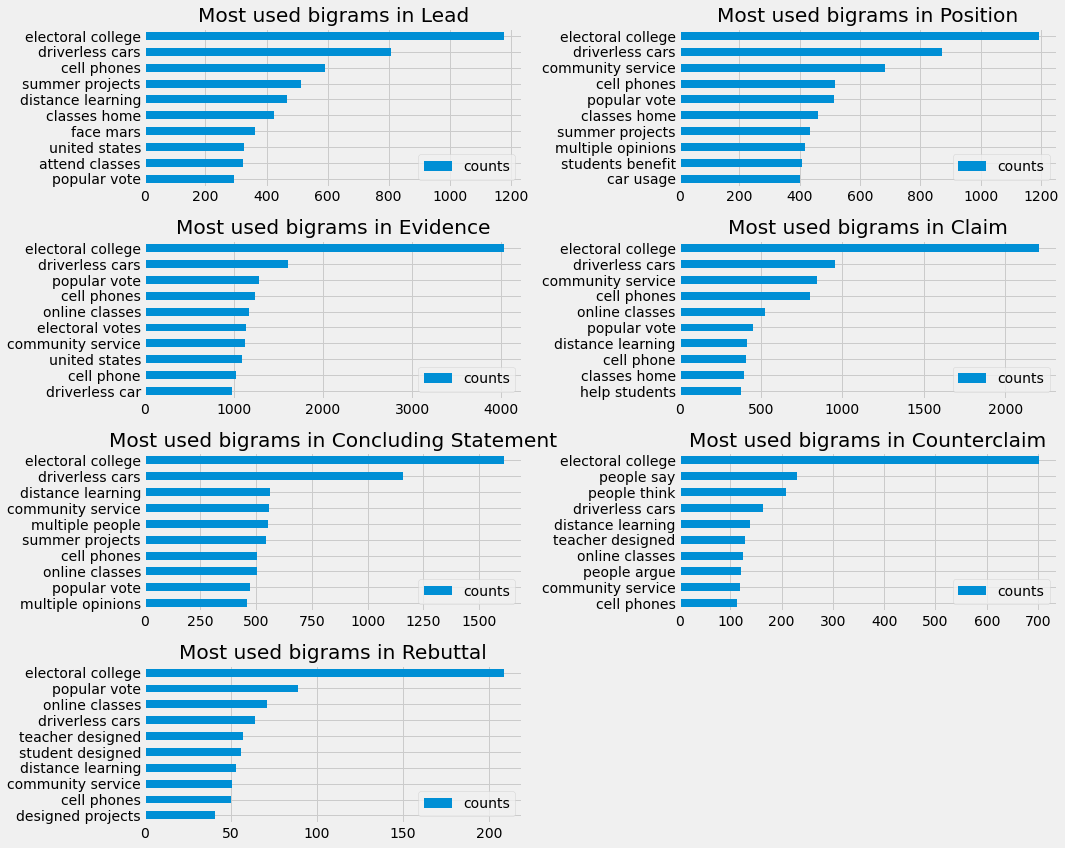

In [41]:
def plot_ngram(df, type = "bigrams"):
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    for n, dt in enumerate(df.Discourse_type.unique()):
        ax = plt.subplot(4, 2, n + 1)
        ax.set_title(f"Most used {type} in {dt}")
        data = df.query('Discourse_type == @dt')[['words', 'counts']].set_index("words").sort_values(by = "counts", ascending = True)
        data.plot(ax=ax, kind = 'barh')
        plt.ylabel("")
    plt.tight_layout()
    plt.show()
    
plot_ngram(bigrams)

  0%|          | 0/7 [00:00<?, ?it/s]

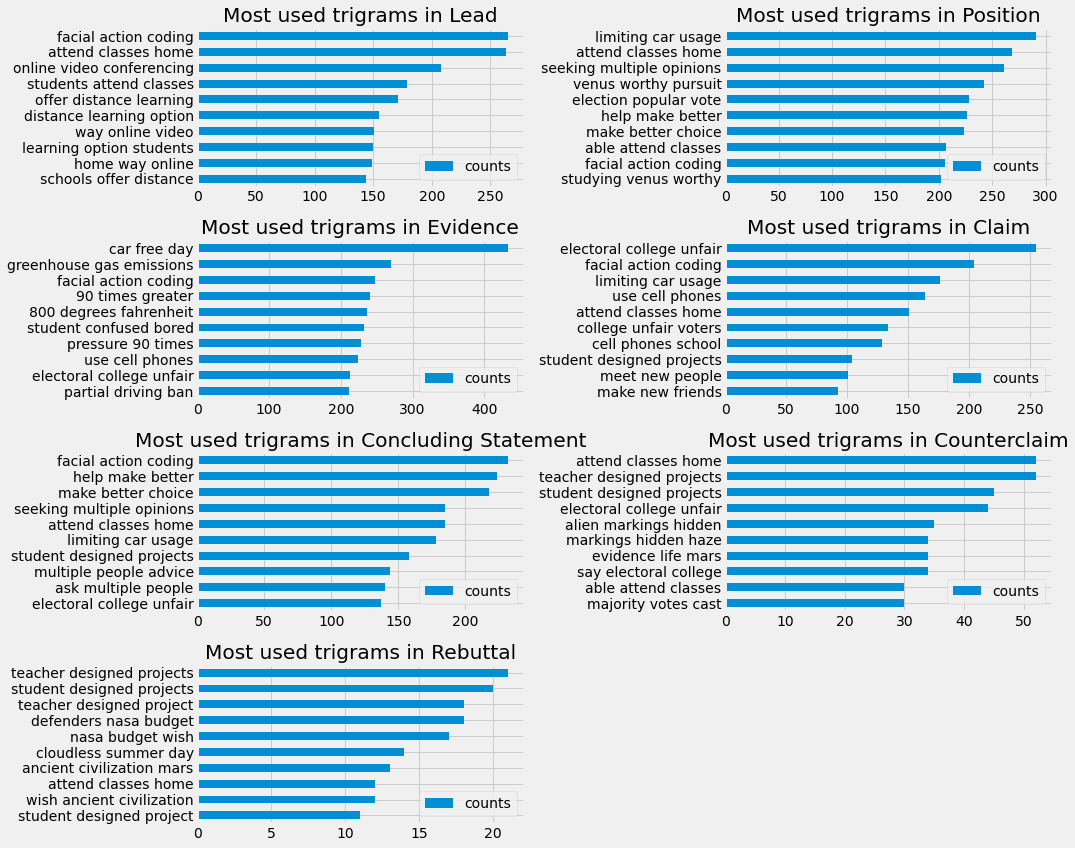

In [42]:
trigrams = get_n_grams(n_grams = 3, top_n=10)
plot_ngram(trigrams, type = "trigrams")